## Acknowledgement
https://www.youtube.com/watch?v=S_il77Ttrmg&list=WL&index=4

## Setup

In [1]:
import matplotlib.pyplot as plt
import torch
import urllib
import numpy as np
import PIL
import wandb

from utils import (
    transform, 
    reverse_transform, 
    plot_spatial_noise_distribution, 
    plot_noise_distribution,
    IMAGE_SHAPE 
)
from model import UNet, DiffusionModel

wandb.login()

wandb: Currently logged in as: peter-thomas-mchale. Use `wandb login --relogin` to force relogin


True

In [2]:
device = torch.device("cuda:0")

In [3]:
def get_sample_image()-> PIL.Image.Image:
    url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTZmJy3aSZ1Ix573d2MlJXQowLCLQyIUsPdniOJ7rBsgG4XJb04g9ZFA9MhxYvckeKkVmo&usqp=CAU'
    filename = 'racoon.jpg'
    urllib.request.urlretrieve(url, filename)
    return PIL.Image.open(filename)

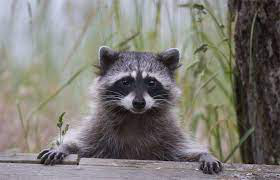

In [4]:
get_sample_image()

In [5]:
pil_image = get_sample_image()
torch_image = transform(pil_image)

In [6]:
diffusion_model = DiffusionModel()

## Forward diffusion process

<Figure size 1500x1500 with 0 Axes>

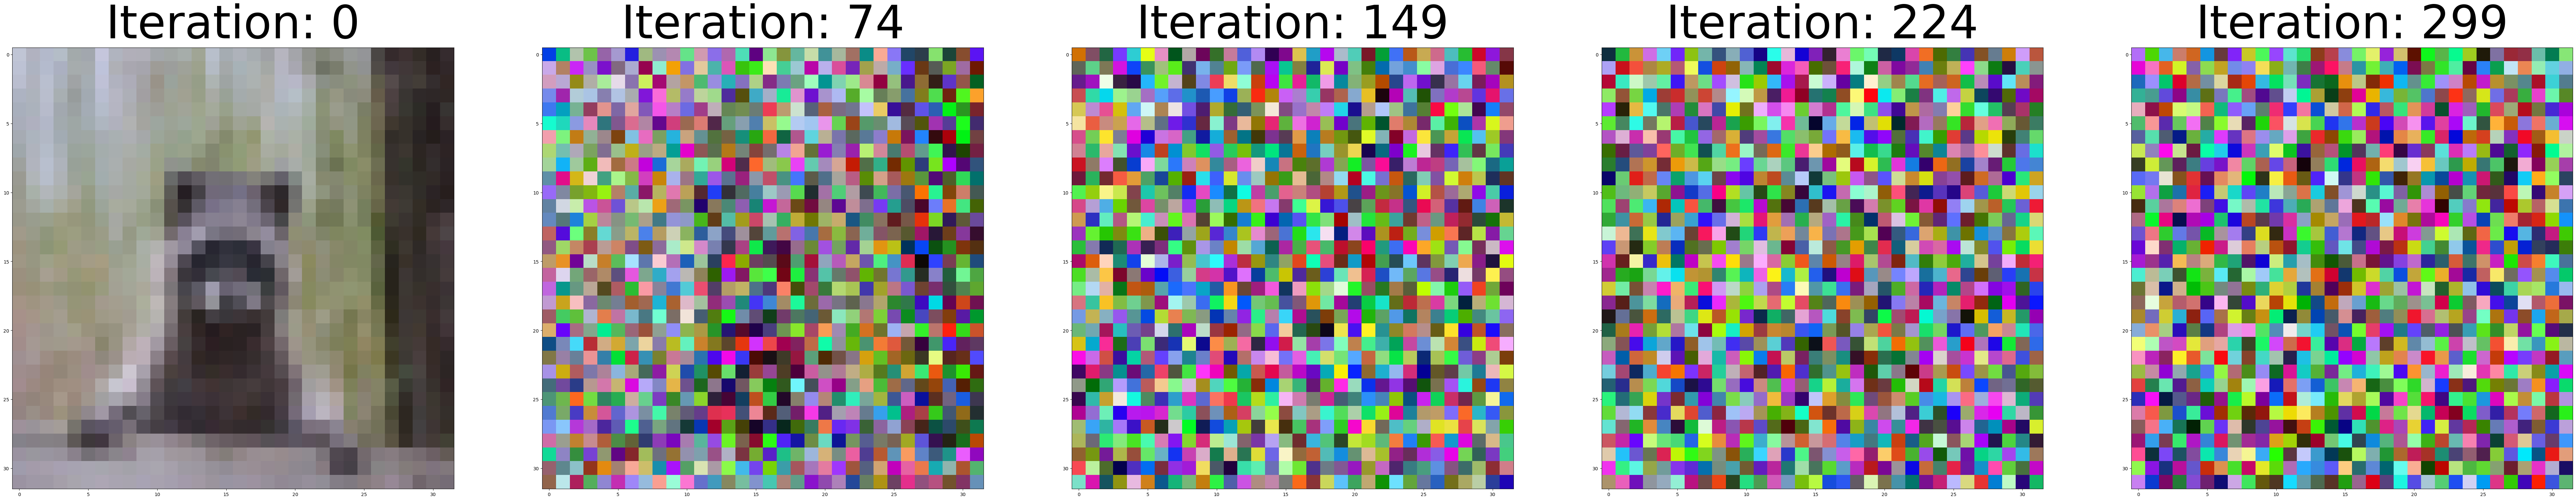

In [7]:
NO_DISPLAY_IMAGES = 5
torch_image_batch = torch.stack([torch_image] * NO_DISPLAY_IMAGES)
t = torch.linspace(0, diffusion_model.timesteps - 1, NO_DISPLAY_IMAGES).long()
noisy_image_batch, _ = diffusion_model.forward(torch_image_batch, t, device)

plt.figure(figsize=(15,15))
f, ax = plt.subplots(1, NO_DISPLAY_IMAGES, figsize = (100,100))

for idx, image in enumerate(noisy_image_batch):
    ax[idx].imshow(reverse_transform(image))
    ax[idx].set_title(f"Iteration: {t[idx].item()}", fontsize = 100)
plt.show()
    

## Overfit to racoon image

In [8]:
NO_EPOCHS = 2000
PRINT_FREQUENCY = 400
LR = 0.001
BATCH_SIZE = 128
VERBOSE = True

unet = UNet(labels=False)
unet.to(device)
optimizer = torch.optim.Adam(unet.parameters(), lr=LR)

---
Epoch: 0 | Train Loss 1.02589750289917


<Figure size 640x480 with 0 Axes>

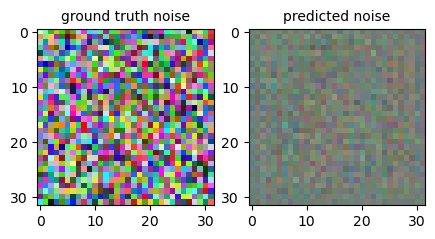

<Figure size 640x480 with 0 Axes>

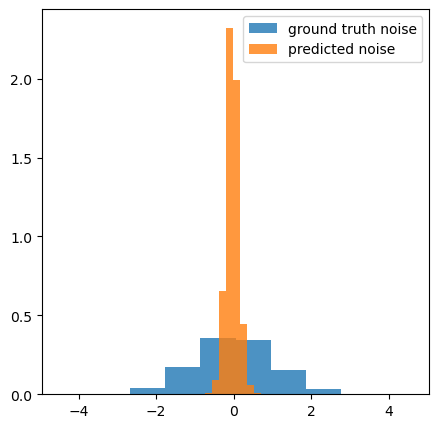

---
Epoch: 400 | Train Loss 0.014485917054116726


<Figure size 640x480 with 0 Axes>

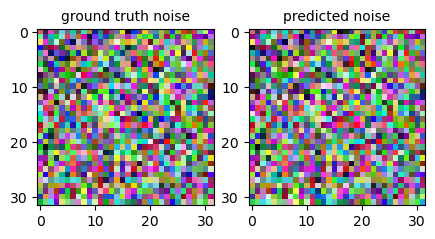

<Figure size 640x480 with 0 Axes>

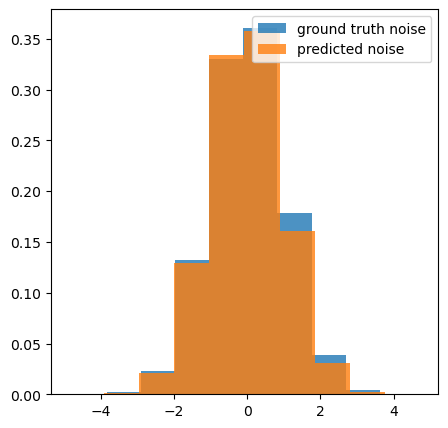

---
Epoch: 800 | Train Loss 0.008439159952104092


<Figure size 640x480 with 0 Axes>

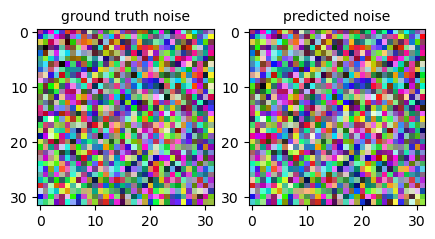

<Figure size 640x480 with 0 Axes>

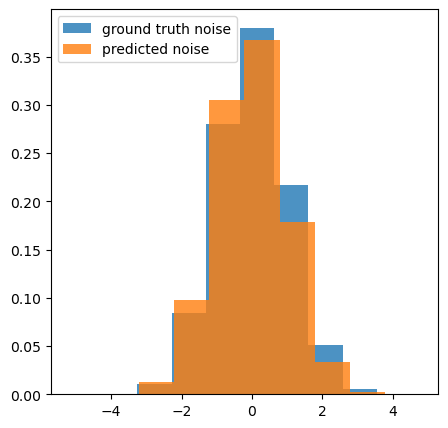

---
Epoch: 1200 | Train Loss 0.007102365605533123


<Figure size 640x480 with 0 Axes>

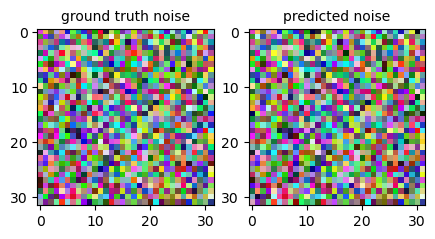

<Figure size 640x480 with 0 Axes>

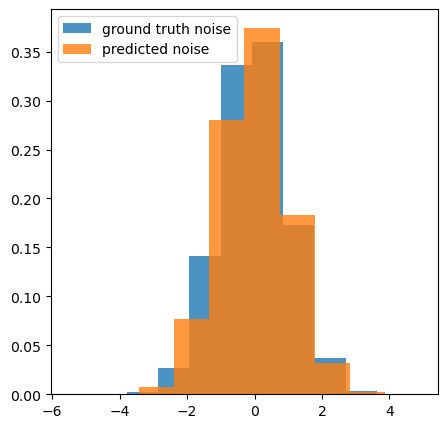

---
Epoch: 1600 | Train Loss 0.006602940149605274


<Figure size 640x480 with 0 Axes>

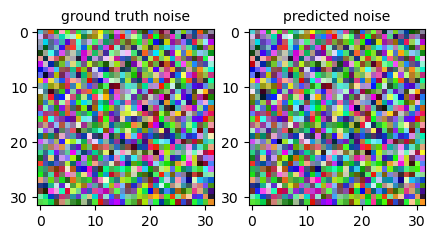

<Figure size 640x480 with 0 Axes>

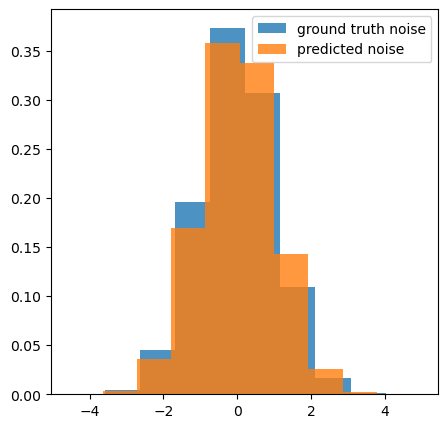

train loss,█▄▃▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train loss,0.00575


In [9]:
wandb.init(
  project='diffusion-overfit-to-racoon',
  # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10):
  # name=f"XXX",
  config={
  "learning_rate": LR,
  "architecture": "diffusion",
  "dataset": "racoon",
  "epochs": NO_EPOCHS,
  })
    
for epoch in range(NO_EPOCHS):
    mean_epoch_loss = []
    
    batch = torch.stack([torch_image] * BATCH_SIZE)
    t = torch.randint(0, diffusion_model.timesteps, (BATCH_SIZE,)).long().to(device)

    batch_noisy, noise = diffusion_model.forward(batch, t, device) 
    predicted_noise = unet(batch_noisy, t)
    
    optimizer.zero_grad()
    loss = torch.nn.functional.mse_loss(noise, predicted_noise) 
    mean_epoch_loss.append(loss.item())
    loss.backward()
    optimizer.step()
    
    loss = np.mean(mean_epoch_loss)
    wandb.log({"train loss": loss})
    
    if epoch % PRINT_FREQUENCY == 0:
        print('---')
        print(f"Epoch: {epoch} | Train Loss {loss}")
        if VERBOSE:
            with torch.no_grad():
                plot_spatial_noise_distribution(noise[0], predicted_noise[0])
                plot_noise_distribution(noise, predicted_noise)
                
wandb.finish()

## Use racoon diffusion model to regenerate racoon image from pure noise

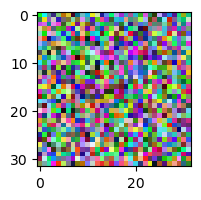

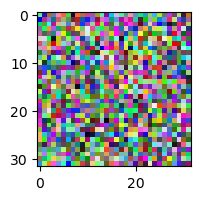

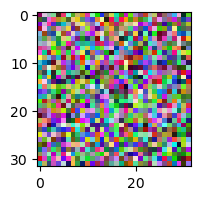

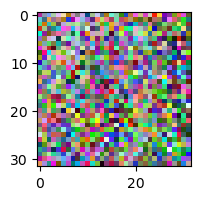

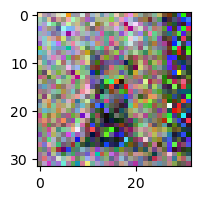

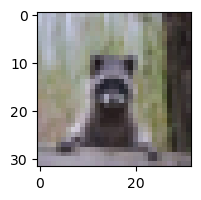

In [10]:
with torch.no_grad():
    img = torch.randn((1, 3) + IMAGE_SHAPE).to(device)
    for i in reversed(range(diffusion_model.timesteps)):
        t = torch.full((1,), i, dtype=torch.long, device=device)
        img = diffusion_model.backward(img, t, unet.eval())
        if i % 50 == 0:
            plt.figure(figsize=(2,2))
            plt.imshow(reverse_transform(img[0]))
            plt.show()
            